# ENAS: Efficient Neural Architecture Search via Parameter Sharing

Implement ENAS for CIFAR-10 dataset. Compare with random structure selection. Model: 3-layer network. Structure: binary mask for each parameter. Plots: model peformance, mask.

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import torch.nn.functional as F


class DynamicMLP(nn.Module):
    def __init__(self, input_dim, max_layer1_neurons, max_layer2_neurons, output_dim):
        super(DynamicMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, max_layer1_neurons)
        self.fc2 = nn.Linear(max_layer1_neurons, max_layer2_neurons)
        self.fc3 = nn.Linear(max_layer2_neurons, output_dim)
        self.mask_layer1 = None
        self.mask_layer2 = None

    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, input_dim)))
        x = x * self.mask_layer1.expand_as(x)
        x = F.relu(self.fc2(x))
        x = x * self.mask_layer2.expand_as(x)
        x = self.fc3(x)
        return x

    def apply_mask(self, mask_layer1, mask_layer2):
        self.mask_layer1 = mask_layer1
        self.mask_layer2 = mask_layer2

In [24]:
class Controller(nn.Module):
    def __init__(self, max_layer1_neurons, max_layer2_neurons, hidden_dim, num_layers):
        super(Controller, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_size=3 * 32 * 32, hidden_size=hidden_dim, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, max_layer1_neurons + max_layer2_neurons)
        self.log_probs = None

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim)

        out, (h_n, c_n) = self.lstm(x.view(batch_size, -1).unsqueeze(0), (h_0, c_0))
        mask_logits = self.fc(h_n[-1])

        mask_logits_layer1 = mask_logits[:, :max_layer1_neurons]
        mask_logits_layer2 = mask_logits[:, max_layer1_neurons:max_layer1_neurons + max_layer2_neurons]
        mask_layer1 = torch.sigmoid(mask_logits_layer1).mean(0) > 0.5
        mask_layer2 = torch.sigmoid(mask_logits_layer2).mean(0) > 0.5

        return mask_layer1.float(), mask_layer2.float(), mask_logits

    def sample_masks(self):
        x = torch.zeros(1, 1, 3 * 32 * 32)  # Фиктивный вход для генерации маски
                              # (не очень понял из статьи как надо на самом деле, возможно, стоило генерить рандомно)
        mask_layer1, mask_layer2, log_probs = self.forward(x)
        self.log_probs = log_probs
        return mask_layer1, mask_layer2

In [6]:
def train_shared_child_parameters(controller, mlp_model, trainloader, optimizer):
    mlp_model.train()
    for inputs, targets in trainloader:
        optimizer.zero_grad()

        inputs = inputs.view(-1, 3 * 32 * 32)
        mask_layer1, mask_layer2, _ = controller.forward(inputs)

        mlp_model.apply_mask(mask_layer1, mask_layer2)
        outputs = mlp_model(inputs)
        loss = F.cross_entropy(outputs, targets)

        loss.backward()
        optimizer.step()
    return loss.item()

In [12]:
def evaluate(model, testloader):
    model.eval()
    total_loss = 0
    total_count = 0

    with torch.no_grad():
        for x, y in testloader:
            output = model(x)
            loss = F.cross_entropy(output, y)
            total_loss += loss.item() * x.size(0)
            total_count += x.size(0)

    avg_loss = total_loss / total_count
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity

In [8]:
def train(controller, mlp_model, optimizer, trainloader, testloader, num_epochs, num_layers):
    metrics = {'loss': [], 'reward': []}
    for epoch in range(num_epochs):

        # Train DynamicMLP
        train_loss = train_shared_child_parameters(controller, mlp_model, trainloader, optimizer)

        # Train Controller using REINFORCE
        mask_layer1, mask_layer2 = controller.sample_masks()
        mlp_model.apply_mask(mask_layer1, mask_layer2)

        valid_ppl = evaluate(mlp_model, testloader)
        reward = 10 / valid_ppl

        optimizer.zero_grad()
        policy_loss = [-log_prob * reward for log_prob in controller.log_probs]
        policy_loss = torch.cat(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()

        metrics['loss'].append(train_loss)
        metrics['reward'].append(reward)
        print(f'Epoch {epoch+1}, Total Loss: {train_loss:.6f}, Total Reward: {reward:.6f}')
    return metrics

In [9]:
input_dim = 3072  # Размер входных данных CIFAR-10
hidden_dim = 100  # Размер скрытого слоя LSTM
num_layers = 5  # Число слоев в LSTM
output_dim = 10  # Количество классов в CIFAR-10
max_layer1_neurons = 400
max_layer2_neurons = 100


controller = Controller(max_layer1_neurons, max_layer2_neurons, hidden_dim, num_layers)
mlp_model = DynamicMLP(input_dim, max_layer1_neurons, max_layer2_neurons, output_dim)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)


metrics = train(controller, mlp_model, optimizer, trainloader, testloader, num_epochs=20, num_layers=5)

Epoch 1, Total Loss: 1.330101, Total Reward: 2.223372
Epoch 2, Total Loss: 1.555143, Total Reward: 2.383873
Epoch 3, Total Loss: 1.328307, Total Reward: 2.453218
Epoch 4, Total Loss: 1.383363, Total Reward: 2.537764
Epoch 5, Total Loss: 1.218822, Total Reward: 2.566392
Epoch 6, Total Loss: 1.231076, Total Reward: 2.556338
Epoch 7, Total Loss: 1.102853, Total Reward: 2.555890
Epoch 8, Total Loss: 1.072365, Total Reward: 2.567575
Epoch 9, Total Loss: 0.970481, Total Reward: 2.491430
Epoch 10, Total Loss: 1.007844, Total Reward: 2.482187
Epoch 11, Total Loss: 1.300899, Total Reward: 2.367444
Epoch 12, Total Loss: 0.947235, Total Reward: 2.283895
Epoch 13, Total Loss: 0.969275, Total Reward: 2.256235
Epoch 14, Total Loss: 0.700988, Total Reward: 2.249956
Epoch 15, Total Loss: 0.771694, Total Reward: 2.145426
Epoch 16, Total Loss: 0.779542, Total Reward: 2.082636
Epoch 17, Total Loss: 0.857921, Total Reward: 2.011847
Epoch 18, Total Loss: 0.511583, Total Reward: 1.951934
Epoch 19, Total Los

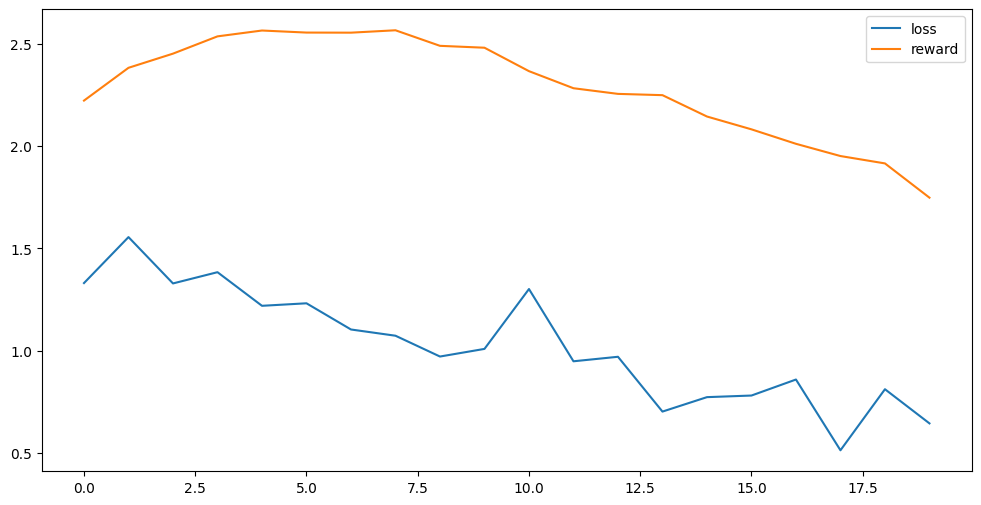

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(metrics['loss'], label='loss')
plt.plot(metrics['reward'], label='reward')
plt.legend()
plt.show()

Довольно странная поведение у графика Reward функции. Возможно, чтобы работал алгоритм Reinforce надо получать маски не по фиктивному входу, либо выбрать другие гиперпараметры

In [21]:
from tqdm import trange

def RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons):
    mask_layer1 = torch.rand(max_layer1_neurons) > 0.5
    mask_layer2 = torch.rand(max_layer2_neurons) > 0.5
    return mask_layer1.float(), mask_layer2.float()

rnd_mlp_model = DynamicMLP(input_dim, max_layer1_neurons, max_layer2_neurons, output_dim)
num_iterations = 50

best_reward = -float('inf')
best_mask = RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons)

for i in trange(num_iterations):
    mask_layer1, mask_layer2 = RandomSelectionSearch(max_layer1_neurons, max_layer2_neurons)

    rnd_mlp_model.apply_mask(mask_layer1, mask_layer2)
    valid_ppl = evaluate(rnd_mlp_model, testloader)
    reward = 10 / valid_ppl

    if reward > best_reward:
        best_reward = reward
        best_mask = mask_layer1, mask_layer2
        print(f"New Best Reward: {best_reward:.6f}")

rnd_mlp_model.apply_mask(*best_mask)

  2%|▏         | 1/50 [00:02<02:10,  2.66s/it]

New Best Reward: 0.996075


  4%|▍         | 2/50 [00:06<02:35,  3.23s/it]

New Best Reward: 0.996805


  6%|▌         | 3/50 [00:09<02:28,  3.16s/it]

New Best Reward: 0.998629


 24%|██▍       | 12/50 [00:37<01:54,  3.02s/it]

New Best Reward: 0.999045


100%|██████████| 50/50 [02:29<00:00,  2.99s/it]


Видим, что RandomSelectionSearch не может получить модель с reward > 1, в отличие от ENAS

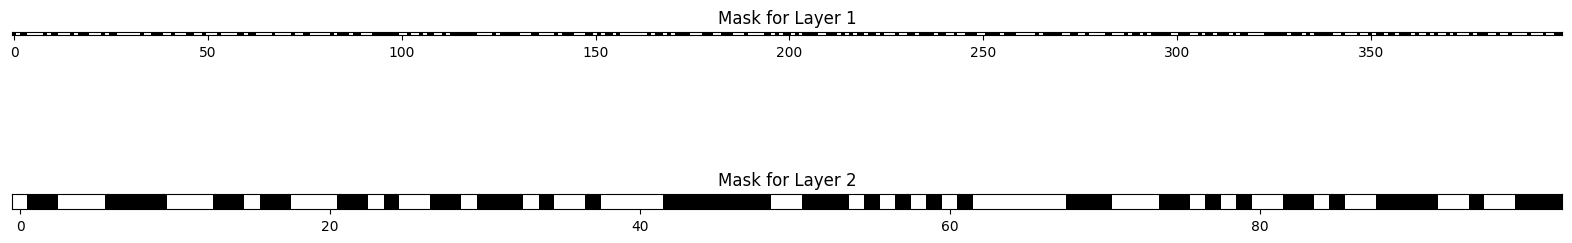

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_masks(mask_layer1, mask_layer2):
    mask_layer1_np = mask_layer1.cpu().numpy()
    mask_layer2_np = mask_layer2.cpu().numpy()

    # Визуализация маски для слоя 1
    plt.figure(figsize=(20, 4))
    plt.subplot(2, 1, 1)
    plt.imshow(mask_layer1_np[np.newaxis, :], cmap='binary')
    plt.title("Mask for Layer 1")
    plt.yticks([])

    # Визуализация маски для слоя 2
    plt.subplot(2, 1, 2)
    plt.imshow(mask_layer2_np[np.newaxis, :], cmap='binary')
    plt.title("Mask for Layer 2")
    plt.yticks([])

    plt.show()

visualize_masks(mlp_model.mask_layer1, mlp_model.mask_layer2)

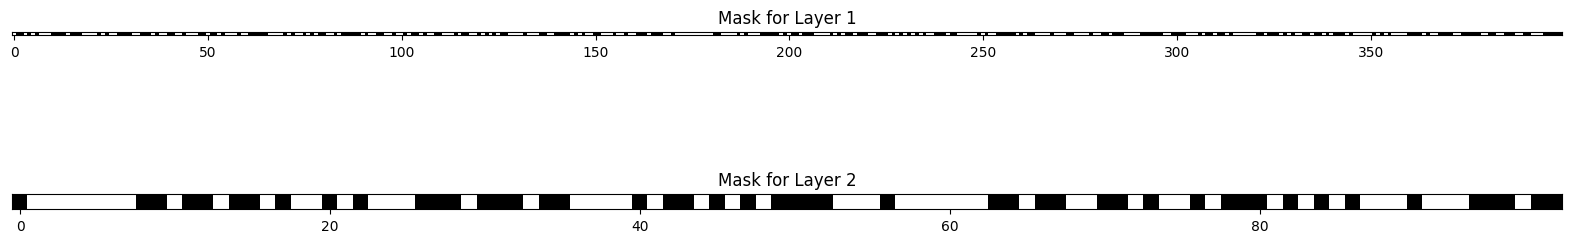

In [20]:
# best_mask -- лучшие маски для RandomSelectionSearch
visualize_masks(*best_mask)